__EPV (Expected Possession Value)__

In [2]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv

In [3]:
# set up initial path to data
DATADIR = 'C:/Users/User/Desktop/Datasets/This is the fourth lecture/sample-data-master/sample-data-master/data'

game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

Reading team: home
Reading team: away


In [4]:
""" *** UPDATES TO THE MODEL: OFFSIDES """
# first get pitch control model parameters
params = mpc.default_model_params()
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

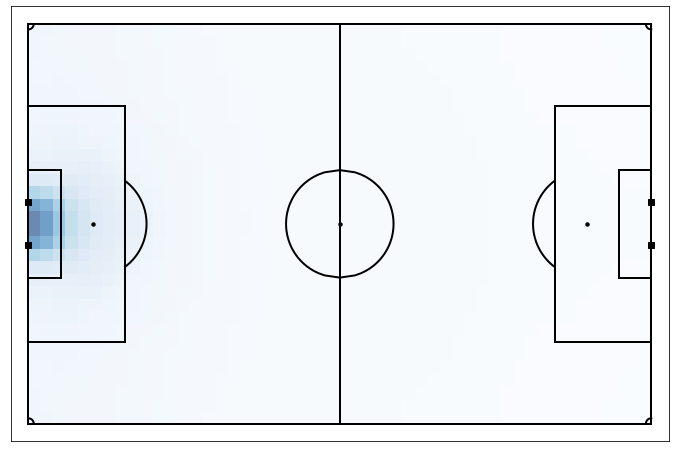

In [7]:
""" *** GET EPV SURFACE **** """
home_attack_direction = mio.find_playing_direction(tracking_home,'Home') # 1 if shooting left-right, else -1

DATADIR = 'C:/Users/User/Desktop/Datasets/This is the fourth lecture/LaurieOnTracking-master/LaurieOnTracking-master'
EPV = mepv.load_EPV_grid(DATADIR+'/EPV_grid.csv')

# plot the EPV surface
mviz.plot_EPV(EPV,field_dimen=(106.0,68),attack_direction=home_attack_direction)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

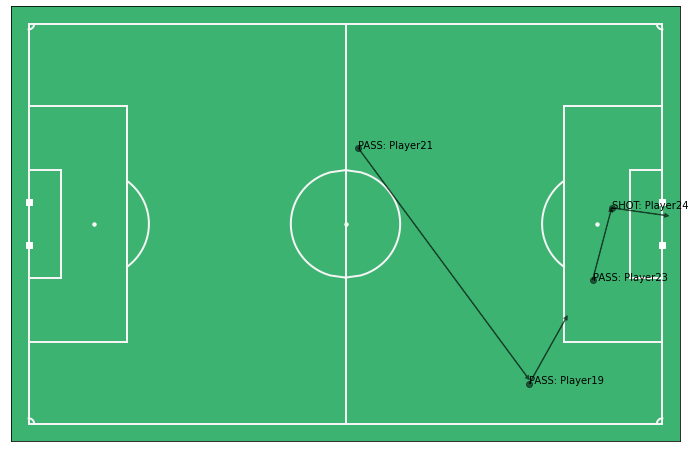

In [8]:
# plot event leading up to first away team goal
mviz.plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed 

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

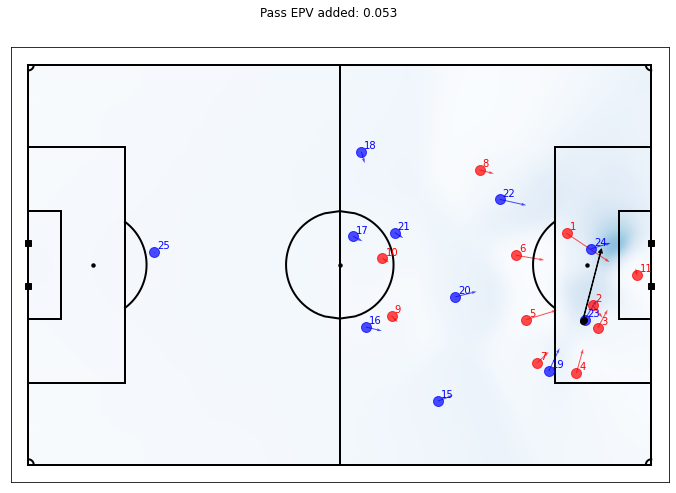

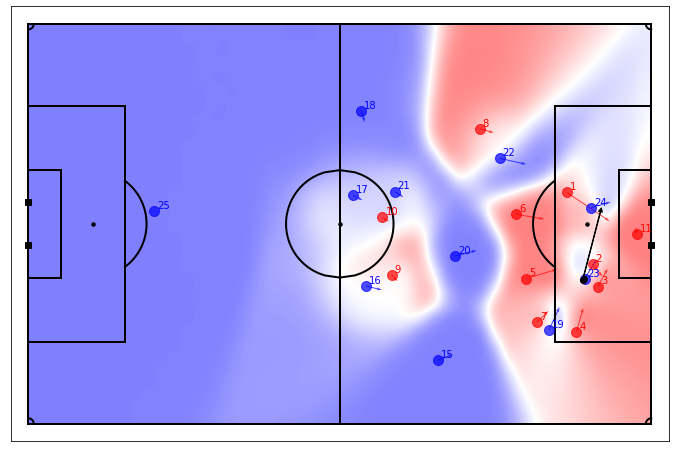

In [9]:
# Calculate value-added for assist and plot expected value surface
event_number = 822 # away team first goal
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True)

In [12]:
""" **** calculate value-added for all passes **** """

# first get all shots
shots = events[events['Type']=='SHOT']
home_shots = shots[shots['Team']=='Home']
away_shots = shots[shots['Team']=='Away']

# get all  passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]
away_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Away') ]

# home team value added
home_pass_value_added = []
for i,pass_ in home_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    home_pass_value_added.append( (i,EEPV_added,EPV_diff ) )
    
# away team value added
away_pass_value_added = []
for i,pass_ in away_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    away_pass_value_added.append( (i,EEPV_added,EPV_diff ) )
    
home_pass_value_added = sorted(home_pass_value_added, key = lambda x: x[1], reverse=True)  
away_pass_value_added = sorted(away_pass_value_added, key = lambda x: x[1], reverse=True)  
    
print("Top 5 home team passes by expected EPV-added")
print(home_pass_value_added[:5])
print('\n')
print("Top 5 away team passes by expected EPV-added")
print(away_pass_value_added[:5])

Top 5 home team passes by expected EPV-added
[(1753, 0.09134393894242623, 0.2252), (1478, 0.07256624699798692, 0.36379999999999996), (197, 0.06171398533066253, 0.2444), (430, 0.048489233171870066, 0.10749999999999998), (851, 0.04528996595787502, 0.1001)]


Top 5 away team passes by expected EPV-added
[(1663, 0.07350679988214359, 0.0378), (961, 0.07103134497968046, 0.1555), (1901, 0.06363375695912829, 0.2474), (822, 0.052764729064602174, 0.0664), (1735, 0.0318116338246547, -0.005600000000000001)]


C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed 

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

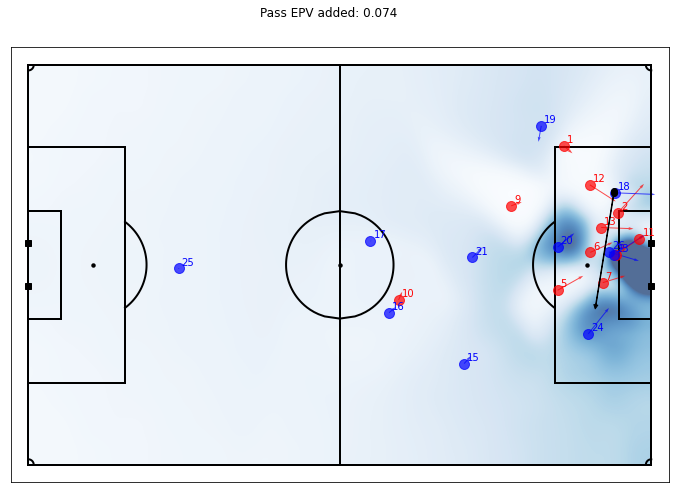

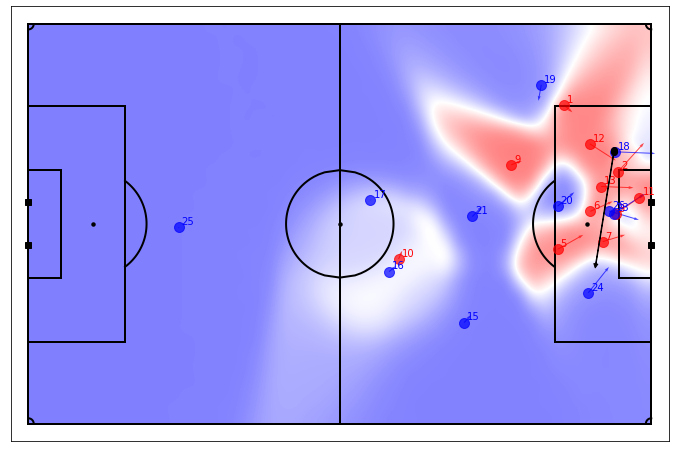

In [16]:
event_number = 1663 # away team assisst to blocked shot
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True )

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed 

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

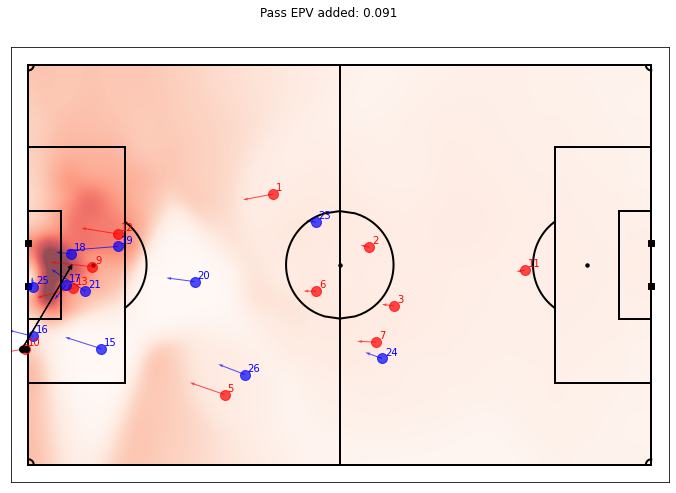

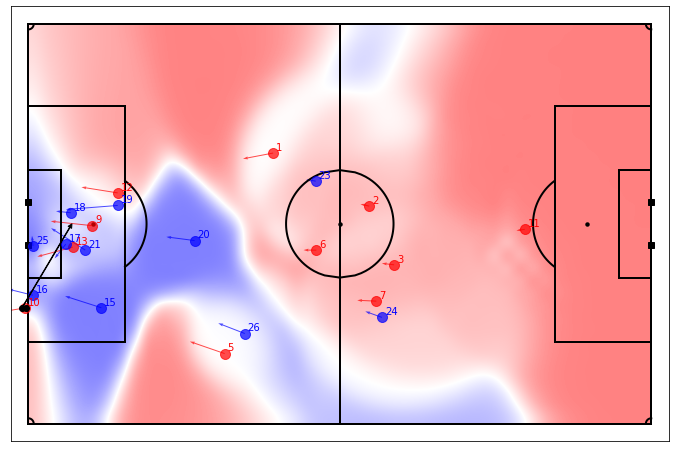

In [13]:
event_number = 1753 # home team assist to header off target
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True )

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed 

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

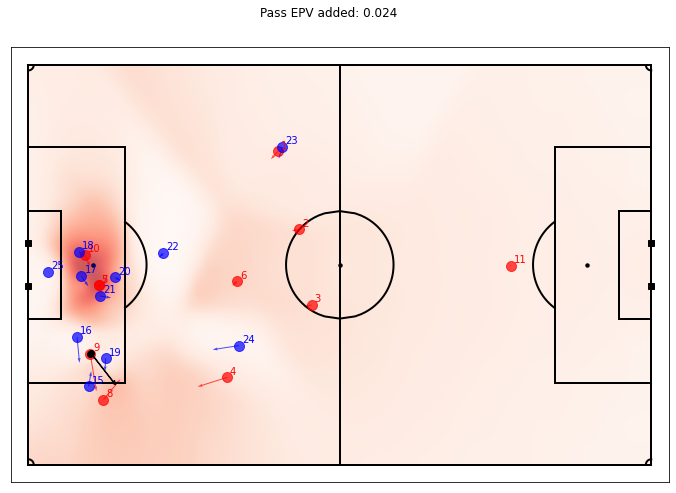

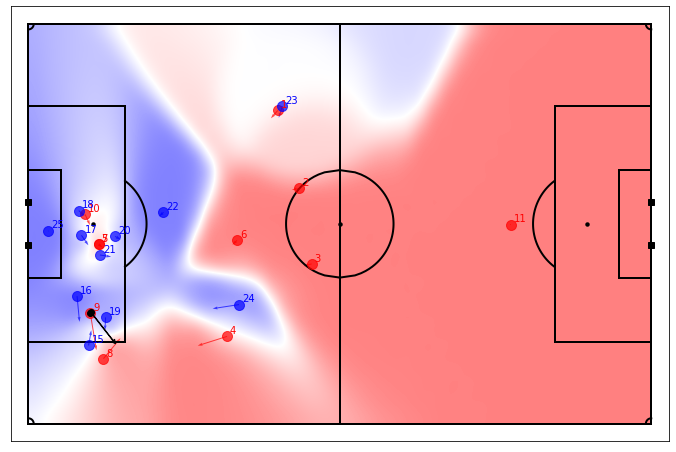

In [15]:
# retaining possession
event_number = 195
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )
mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True )

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)


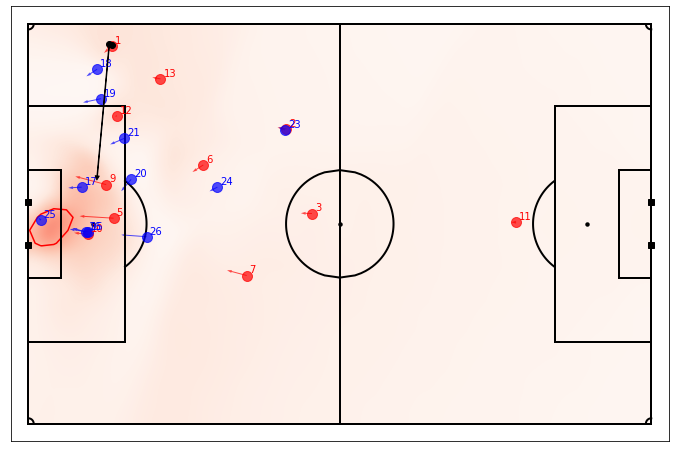

In [17]:
# assist example
event_number = 1680
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True, contours=True )

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed 

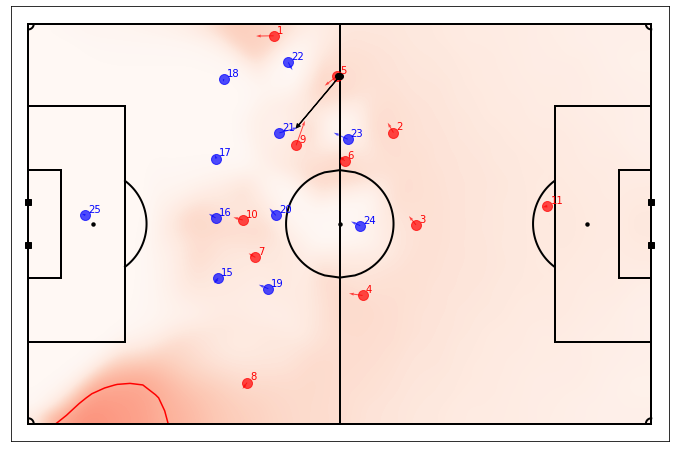

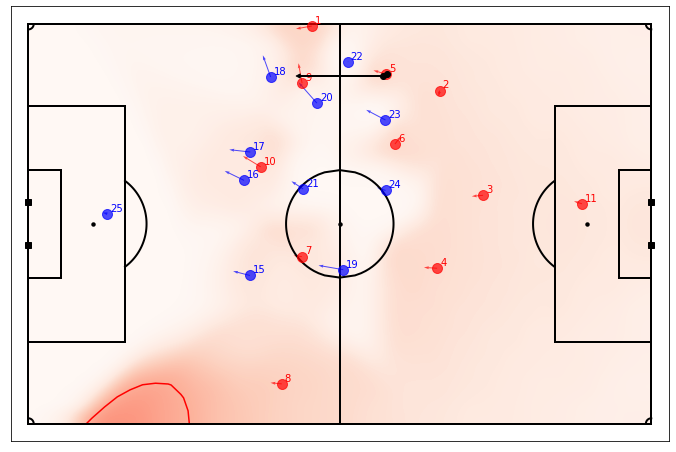

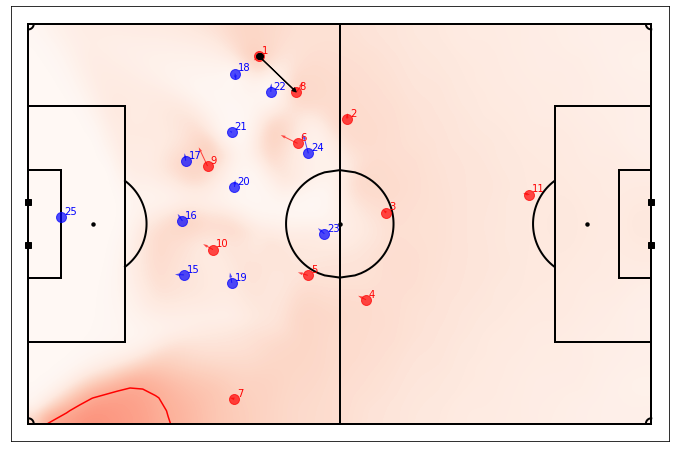

In [19]:
# cross-field passes
examples = [403,68,829]
for event_number in examples:
    PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
    fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True, contours=True )            